# Importing Packages

In [83]:
# Load data
import torch
import torchvision
from torchvision import datasets, models, transforms, utils

# Visualize data
import numpy as np
import matplotlib.pyplot as plt

# Training
from tempfile import TemporaryDirectory
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from PIL import Image
import time
import os

torch.cuda.empty_cache()
cudnn.benchmark = True
plt.ion()   # interactive mode

# Load Data

In [84]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transform = {
    'train' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5,], [0.5,])
    ]),

    'test' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5,], [0.5,])
    ]),
}

data_dir = '/home/moritz/git/group_mfja_emnist/'

image_datasets = {
    'train': datasets.EMNIST(
        root = data_dir,
        split = 'balanced',
        train = True,
        download = True,
        transform = data_transform['train']
    ),

    'test': datasets.EMNIST(
        root = data_dir,
        split = 'balanced',
        train = False,
        download = True,
        transform = data_transform['test']
    )
}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=(x == 'train'))
    for x in ['train', 'test']
}

class_names = image_datasets['train'].classes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize Data

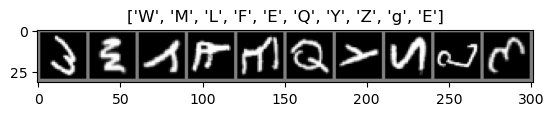

In [85]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5,])
    std = np.array([0.5,])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:10], nrow=10)

imshow(out, title=[class_names[x] for x in classes[:10]])

Training the model
==================

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [86]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [87]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [88]:
model_ft = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
num_classes = len(class_names)
model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
==================

It should take around 15-25 min on CPU. On GPU though, it takes less
than a minute.


In [89]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------
train Loss: 0.8190 Acc: 0.7533
test Loss: 0.3988 Acc: 0.8595

Epoch 1/1
----------
train Loss: 0.3688 Acc: 0.8681
test Loss: 0.3424 Acc: 0.8764

Training complete in 1m 32s
Best val Acc: 0.876383


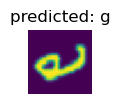

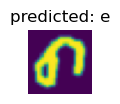

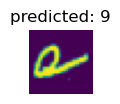

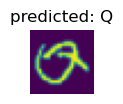

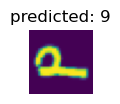

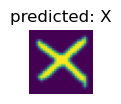

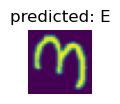

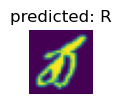

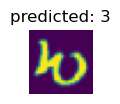

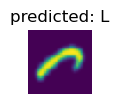

In [90]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
==================================

Here, we need to freeze all the network except the final layer. We need
to set `requires_grad = False` to freeze the parameters so that the
gradients are not computed in `backward()`.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).


In [91]:
model_conv = torchvision.models.resnet50(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_classes)
model_conv.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
==================

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don\'t need to be computed for most of the
network. However, forward does need to be computed.


In [92]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 3.0489 Acc: 0.2391
test Loss: 2.6959 Acc: 0.3132

Epoch 1/4
----------
train Loss: 2.6045 Acc: 0.3250
test Loss: 2.5255 Acc: 0.3473

Epoch 2/4
----------
train Loss: 2.4750 Acc: 0.3520
test Loss: 2.4320 Acc: 0.3676

Epoch 3/4
----------
train Loss: 2.3954 Acc: 0.3673
test Loss: 2.3969 Acc: 0.3718

Epoch 4/4
----------
train Loss: 2.3342 Acc: 0.3821
test Loss: 2.3392 Acc: 0.3832

Training complete in 2m 18s
Best val Acc: 0.383245


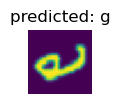

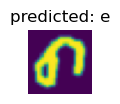

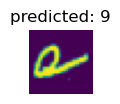

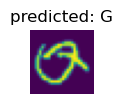

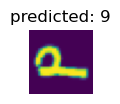

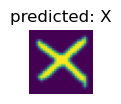

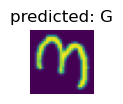

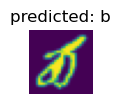

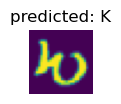

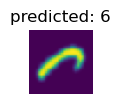

In [93]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Inference on custom images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


In [94]:
def visualize_predictions_fixed(model, dataloader, class_names, num_images=10):

    was_training = model.training
    model.eval()
    
    images_displayed = 0

    fig = plt.figure(figsize=(20, 5))  # Ensure enough horizontal space for 10 images
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if images_displayed == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()  # Fix spacing between subplots
                    plt.show()
                    return

                ax = plt.subplot(1, num_images, images_displayed + 1)
                ax.axis('off')
                ax.set_title(f"Pred: {class_names[preds[i]]}\nReal: {class_names[labels[i]]}", fontsize=8)
                imshow(inputs.cpu().data[i])

                images_displayed += 1

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show()


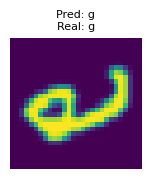

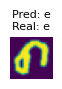

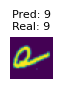

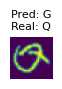

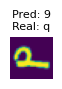

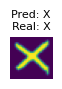

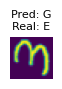

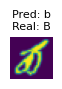

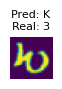

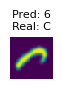

<Figure size 640x480 with 0 Axes>

In [95]:
visualize_predictions_fixed(
    model=model_conv,
    dataloader=dataloaders['test'],
    class_names=class_names,
    num_images=10
)